=====Initializing big simulation=====
 INPUT Parameter summary: 
   Number of time steps: NT=2138 
   Plotting interval: NPLT=40 
   Diffusion coeff: Kyb = 2.080000e+02 (in km^2/yr)
   Growth rate: Ryb = 1.670000e-03 (in yr^{-1})
   MAP SIZE: NX=720 (E-W), NY=360 (N-S)
   CELL size: dx=dy = 111.6 (km)=   0.2 (eq. (3) units)
   eq. (3) step size h=5.000000e-02, and CFL number=4.997623e-01 

   Start time Ts= 65.0 (kya), NPP frame kstart=17

   End time   Te=  1.0 (kya), NPP frame kend=60

=====Plotting Results=====


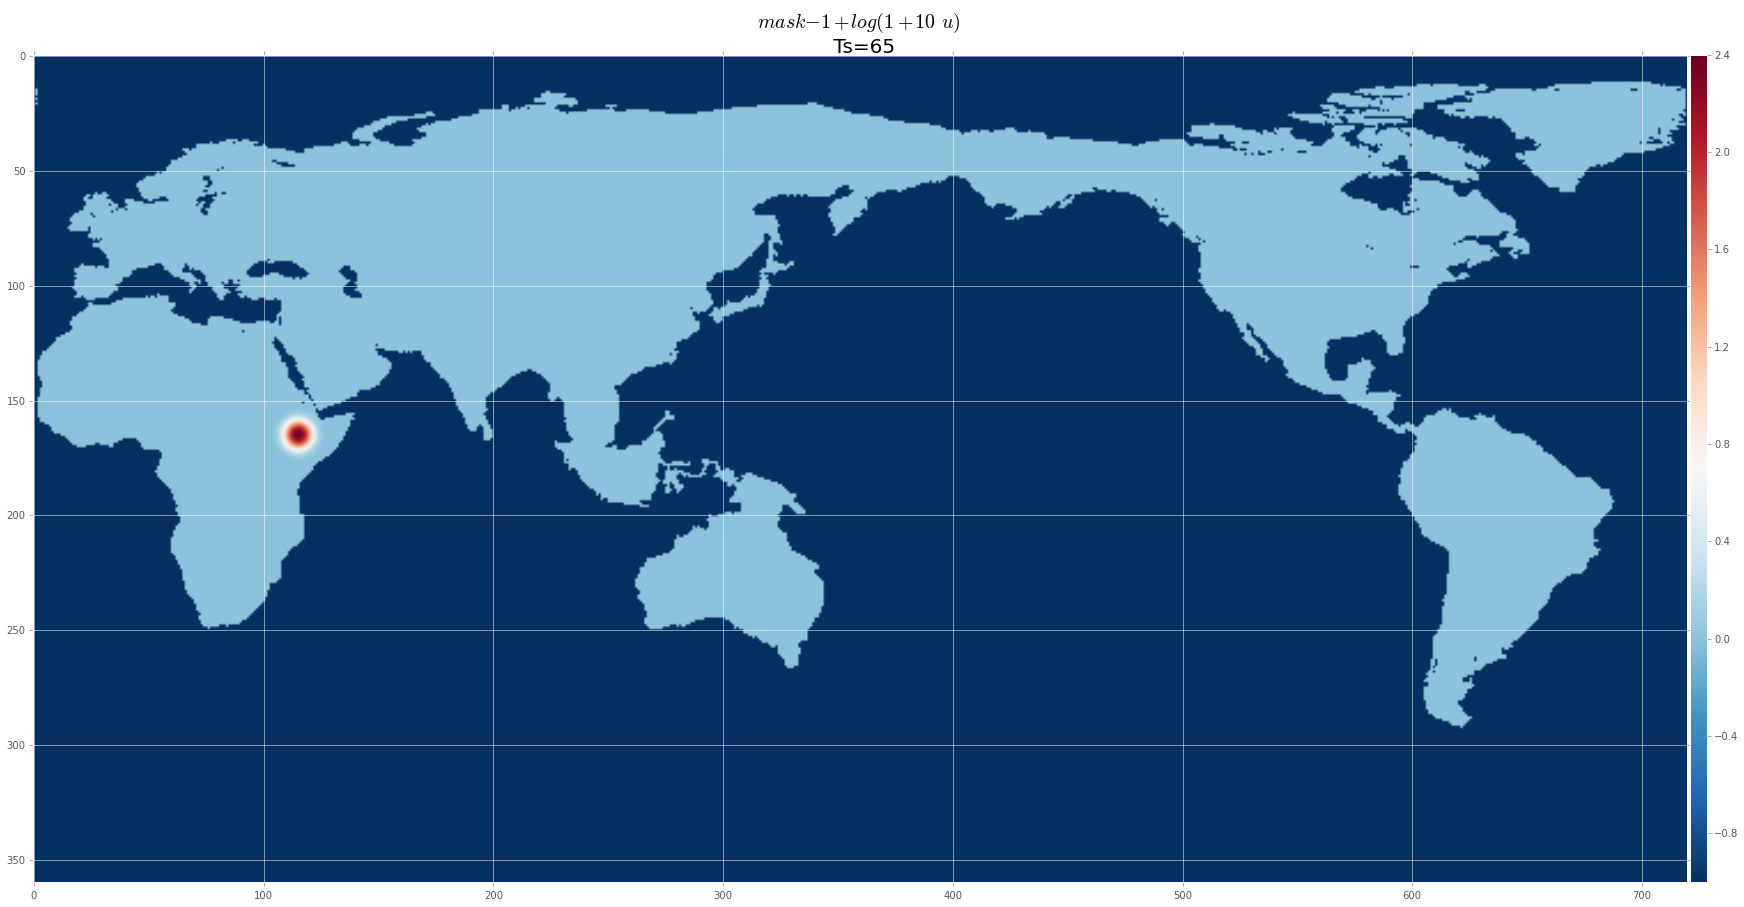

In [1]:
% matplotlib inline
#from strategyTravelingWaves import Simulation
#from strategyTravelingWaves import *
#sim = Simulation('testSmall')
#sim = Simulation('testBig')
from Simulation import *
mapsize = 'big'
#Ts = 10.
#Te = 0.
Ts = 65
Te = 1.
#r = 0.000835
#D = 416.
sim = SerialSimulation(mapsize, Ts, Te)
sim.plot()

In [2]:
import pandas as pd

In [3]:
sites=pd.read_pickle('ArcheologicalSites')
empty = ones(10, dtype=bool)
arrivalTime = zeros(10,dtype=float)

def verify_arrival():
    for i in range(1,10): 
        lat_pix = sites.loc[i]['lat_pix']
        lon_pix = sites.loc[i]['lon_pix']
        meanKap=0.25*(w_L[lat_pix,lon_pix]+w_H[lat_pix,lon_pix])
        if (sim.data.u[lat_pix,lon_pix]> meanKap) and empty[i]:
            arrivalTime[i] = t
            empty[i] = False

In [63]:
i = 9
lat_pix = sites.loc[i]['lat_pix']
lon_pix = sites.loc[i]['lon_pix']
meanKap=0.25*(w_L[lat_pix,lon_pix]+w_H[lat_pix,lon_pix+2])
print(sim.data.u[lat_pix,lon_pix], meanKap)
print(sim.data.w_map[lat_pix,lon_pix])

(0.012184708375598294, 0.048182279669270855)
1


In [2]:
print("====="+sim.data.mapsize+" simulation Starting=====")
output = False
module = 'C'
#module = 'Python'

#Deciding which booster to use 
if module == 'Fortran':
    #import Fmodules as modules
    #import FmodulesNeumann as modules
    import FmodulesNeumann1 as modules

elif module =='C':
    #import Cmodules as modules
    #import CmodulesNeumann as modules
    import CmodulesNeumann1 as modules
    #import CmodulesNeumann3 as modules

elif module =='Python':
    #import Pymodules as modules 
    #import PymodulesNeumann as modules
    #import PymodulesNeumann1 as modules
    import PymodulesNeumann3 as modules
    
Ts = sim.data.Ts #Time start
Te = sim.data.Te #Time end
tsc = sim.data.tsc #Time descaler
h = sim.data.h #Unitless time step
kcfl = sim.data.kcfl #kcfl
u = sim.data.u

NS = max(sim.data.NY,sim.data.NX) #find max size 
u0 = zeros(NS)         
u1 = zeros(NS) 
kap0 = zeros(NS)
kaph = zeros(NS)

sigmoid = yppoints() #Interpolation points   

# read the CC map lists and times=tepoch's for each frame: find first
# Search for appropriate NPP maps:
#      from start time Ts (in kya) to end time Te
#loading carrying capacities from namelist
yalist, masks, tepoch = get_cc_list(sim.data.mapsize)

kstart, kend = findIndex(tepoch,Ts, Te)

print('   Start time Ts=%5.1f (kya), NPP frame kstart=%d\n'%(Ts,kstart))
print('   End time   Te=%5.1f (kya), NPP frame kend=%d\n'%(Te,kend))

# make sure there are at least 2 maps between Ts and Te
if ((kend-kstart)<1) or ((tepoch[kstart]-tepoch[kend])<(Ts-Te)):
   print('Ts=%e, Te=%e, not space enough: kstart=%d, kend=%d\n'%(Ts,Te,kstart,kend))

#      start and end maps found
kmp = kstart # start counting maps here


#Read masks 
#Read m_L, t_L
#Read m_H, t_H
t_L = tepoch[kmp]
t_H = tepoch[kmp+1]
#Intermediate mask
#Compute m_LH
#read m_LH
m_LH = readTemplateMap(sim.data.mapsize, masks,kmp)

#Read carrying capacities
#Read w_L, w_H
w_L, w_H = readCC(sim.data.mapsize, yalist, kmp)

kmp = kmp+1


# Scan through map, construct segments for X and Y directions 
nxsegs, xstart_seg, xend_seg = Xscan(m_LH)
nysegs, ystart_seg, yend_seg = Yscan(m_LH)

#w_H = kapepoch(self.data.w_map,yalist,kmp, self.data.mapsize) # second map
#t_H = tepoch[kmp]

#Computing interpolation weights 
s   = (t_L-Ts+tsc*h)/(t_L-t_H)  # first step interpolation parameter
wt0 = 0.0
# compute interpoated weight to get to step t=h
ks  = floor(100*s)
sd  = 100*s - ks               # residual sd = 100*s mod 1
#wth = yp[0]*(1-sd) + yp[1]*sd  # first interpolant
wth = sigmoid[ks]*(1-sd) + sigmoid[ks+1]*sd  # first interpolant
t   = Ts                       # this is real time in kya

# TGL alternates between 1 and 0 
TGL = True
imID = 0
#TGL = False

=====big simulation Starting=====
   Start time Ts= 65.0 (kya), NPP frame kstart=17

   End time   Te=  1.0 (kya), NPP frame kend=60



In [3]:
kstart, kend = findIndex(tepoch,Ts, Te)

In [4]:
tepoch[kstart]

66

In [5]:
tepoch[kend]

1

In [16]:
# BEGIN main loop
# sim.NT = 1
it = 0
found = False

In [25]:
from tqdm import *

In [27]:
start = timer()
for it in tqdm(range(0,sim.data.NT)):
#for it in range(0,200):
    #%debug 0
    #print 'iteration=',it 
    if TGL: #First choice: half-step1 in X, and step 2 in Y 
        locX = 0
        #half-step1 in X
        for row in range(0,sim.data.NY):
            nSegs = nxsegs[row] #Number of segments 
            for seg in range(0,nSegs):
                colStart=xstart_seg[locX+seg] #From: segment starts
                colEnd=xend_seg[locX+seg] #To:segmend ends
                nInSeg=colEnd-colStart+1 #Number of inner segments
                

                #print 'u',u.shape
                #print 'i',i
                #print 'jstart',jstart
                #print'jend',jend
                u1[1:nInSeg+1] = u[row,colStart:colEnd+1]

                #Dirichlet
                u1[0] = 0 
                u1[nInSeg+1] = 0
                
                #Neumann
                u1[0] = u1[1]
                u1[nInSeg+1] = u1[nInSeg]
                
                #ut = godunovstep1(ninseg+2,h,kcfl,u1,sc1,sc2)
                #Booster Subroutine
                ut = modules.godunovstep1(h,kcfl,u1[0:nInSeg+2])
                #if(ut[1:nInSeg+1]<0).any():
                #    print('Annihilatio:%d, cols:[%d,%d]'%(row, colStart, colEnd))
                #    ut[ut<0]=0. #Self annihilation when u<0
                    
                if (ut[1:nInSeg+1]<0).any():
                    print('1st Half-Step1 X')
                    print('ut:',ut)
                    raise ValueError('ut less than 0 ')
                #else:
                #    u[row,colStart:colEnd+1] = ut[1:nInSeg+1]
                u[row,colStart:colEnd+1] = ut[1:nInSeg+1]


                
            locX = locX + nSegs #Number of scanned segments
        #step2 in Y-Direction 
        locY = 0
        for col in range(0,sim.data.NX):
            nSegs = nysegs[col]
            for seg in range(0,nSegs):
                rowStart=ystart_seg[locY+seg]
                rowEnd=yend_seg[locY+seg]
                nInSeg=rowEnd-rowStart+1
                #print j #69 ??????
                #print k #0
                #print istart #617
                #print iend #618
                #print ninseg #2

                #print 'it:', it #it 17, 67, 0
                #print 'col:', col
                #print 'rowStart:',rowStart #:678???
                #print 'rowEnd:',rowEnd #679??
                #print 'u0:', u0[1:nInSeg+1].shape # (2,), (26,), (2,)
                #print 'u:',u[rowStart:rowEnd+1,col].shape # (0,), (0,), (0,)
                u0[1:nInSeg+1] = u[rowStart:rowEnd+1,col]
                kap0[0] = 1 
                kap0[nInSeg+1] = 1
                #print 'kaph', kaph[1:ninseg+1].shape
                #print 'w_L', w_L[j,istart:iend+1].shape
                #print 'w_H', w_H[j,istart:iend+1].shape
                kap0[1:nInSeg+1] = w_L[rowStart:rowEnd+1,col]*(1-wt0) + w_H[rowStart:rowEnd+1,col]*wt0
                #if kap0[1:nInSeg+1]==0
                kaph[0] = 1 
                kaph[nInSeg+1] = 1
                kaph[1:nInSeg+1] = w_L[rowStart:rowEnd+1,col]*(1-wth) + w_H[rowStart:rowEnd+1,col]*wth
                #ut = godunovstep2(ninseg+2,h,kcfl,u0,sc1,sc2,kap0,kaph)
                #Booster Subroutine
                #if kap0[0:nInSeg+2].any()==0:
                #    print 'it:', it
                #    print 'kap0:',kap0
                #if kaph[0:nInSeg+2].any() ==0:
                #    print 'it:', it
                #    print 'kaph:',kaph
                
                #Dirichlet
                u0[0] = 0 
                u0[nInSeg+1] = 0

                #Neumann
                u0[0] = u0[1]
                u0[nInSeg+1] = u0[nInSeg]
                
                ut = modules.godunovstep2(h,kcfl,u0[0:nInSeg+2],kap0[0:nInSeg+2],kaph[0:nInSeg+2])
                #if(ut[1:nInSeg+1]<0).any():
                #    print('Annihilation at col:%d, rows:[%d,%d]'%(col, rowStart, rowEnd))
                #    ut[ut<0]=0. #Self annihilation when u<0
                    
                if (ut[1:nInSeg+1]<0).any():
                    print('1st Step Y')
                    print('ut:',ut)
                    raise ValueError('ut less than 0 ') #Error 
                
                u[rowStart:rowEnd+1,col] = ut[1:nInSeg+1]
                
            locY = locY + nSegs
        #half-step1 in X-Direction
        locX = 0
        for row in range(0,sim.data.NY):
            nSegs = nxsegs[row]
            for seg in range(0,nSegs):
                colStart=xstart_seg[locX+seg]
                colEnd=xend_seg[locX+seg]
                nInSeg=colEnd-colStart+1
                
                u1[1:nInSeg+1] = u[row,colStart:colEnd+1]
                #ut = godunovstep1(ninseg+2,h,kcfl,u1,sc1,sc2)
                
                #Dirichlet
                u1[0] = 0
                u1[nInSeg+1] = 0
                
                #Neumann
                u1[0] = u1[1]
                u1[nInSeg+1] = u1[nInSeg]

                #Booster Subroutine
                ut = modules.godunovstep1(h,kcfl,u1[0:nInSeg+2])
                if (ut[1:nInSeg+1]<0).any():
                    print('1st Half Step1 in X')
                    print('ut:',ut)
                    found = True
                    raise ValueError('ut less than 0 ')

                u[row,colStart:colEnd+1] = ut[1:nInSeg+1]

            locX = locX + nSegs
        TGL = False
        

    else:    
        ##Second choice: half-step1 in Y, and step 2 in X 
        locY = 0
        #half-step1 in Y
        for col in range(0,sim.data.NX):
            nSegs = nysegs[col] #Number of segments 
            for seg in range(0,nSegs):
                rowStart=ystart_seg[locY+seg] #From: segment starts
                rowEnd=yend_seg[locY+seg] #To:segmend ends
                nInSeg=rowEnd-rowStart+1
            
                
                u0[1:nInSeg+1] = u[rowStart:rowEnd+1,col]
                #ut = godunovstep1(ninseg+2,h,kcfl,u0,sc1,sc2)
                
                #Dirichlet
                u0[0] = 0
                u0[nInSeg+1] = 0                
                
                #Neumann
                u0[0] = u0[1]
                u0[nInSeg+1] = u0[nInSeg]

                #Booster Subroutine
                ut = modules.godunovstep1(h,kcfl,u0[0:nInSeg+2])
                if (ut[1:nInSeg+1]<0).any():
                    print('2nd Half Step1 in Y')
                    print('ut:',ut)
                    raise ValueError('ut less than 0 ')


                u[rowStart:rowEnd+1,col] = ut[1:nInSeg+1]
            
            locY = locY + nSegs

        #Step 2 : X direction updates
        locX = 0
        for row in range(0,sim.data.NY):
            nSegs = nxsegs[row] #row or col???
            for seg in xrange(0,nSegs):
                colStart=xstart_seg[locX+seg]
                colEnd=xend_seg[locX+seg]
                nInSeg=colEnd-colStart+1
            
                
                u1[1:nInSeg+1] = u[row,colStart:colEnd+1]
                
                kap0[0] = 1 
                kap0[nInSeg+1] = 1
                kap0[1:nInSeg+1] = w_L[row,colStart:colEnd+1]*(1-wt0) + w_H[row,colStart:colEnd+1]*wt0
                #No interpolation
                #kap0[1:ninseg+1] = w_L[i,jstart:jend+1]

                kaph[0] = 1
                kaph[nInSeg+1] = 1
                kaph[1:nInSeg+1] = w_L[row,colStart:colEnd+1]*(1-wth) + w_H[row,colStart:colEnd+1]*wth

                #Dirichlet
                u1[0] = 0 
                u1[nInSeg+1] = 0
                
                #Neumann
                u1[0] = u1[1]
                u1[nInSeg+1] = u1[nInSeg]

                #No interpolation
                #kaph[1:ninseg+1] = w_L[i,jstart:jend+1]

                #ut = godunovstep2(ninseg+2,h,kcfl,u1,sc1,sc2,kap0,kaph)
                #Fortran Subroutine
                #if kap0[0:nInSeg+2].any()==0:
                #    print 'it:', it
                #    print 'kap0:',kap0
                #if kaph[0:nInSeg+2].any() ==0:
                #    print 'it:', it
                #    print 'kaph:',kaph
                    
                ut = modules.godunovstep2(h,kcfl,u1[0:nInSeg+2],kap0[0:nInSeg+2],kaph[0:nInSeg+2])
                #if(ut[1:nInSeg+1]<0).any():
                #    print('Annihilation at cols:[%d,%d], row:%d'%(colStart, colEnd, row))
                #    ut[ut<0]=0. #Self annihilation when u<0
                    
                if (ut[1:nInSeg+1]<0).any():
                    print('2nd Step in X')
                    print('ut:',ut)
                    raise ValueError('ut less than 0 ')

                
                u[row,colStart:colEnd+1] = ut[1:nInSeg+1]


            locX = locX + nSegs

        # half step1 in Y direction
        locY = 0
        for col in range(0,sim.data.NX):
            nSegs = nysegs[col]
            for seg in range(0,nSegs):
                rowStart=ystart_seg[locY+seg]
                rowEnd=yend_seg[locY+seg]
                nInSeg=rowEnd-rowStart+1
                
                u0[1:nInSeg+1] = u[rowStart:rowEnd+1,col]

                #Dirichlet
                u0[0] = 0
                u0[nInSeg+1] = 0
                
                #Neumann
                u0[0] = u0[1]
                u0[nInSeg+1] = u0[nInSeg]
                
                #ut = godunovstep1(ninseg+2,h,kcfl,u0,sc1,sc2)
                #Booster Subroutine
                ut = modules.godunovstep1(h,kcfl,u0[0:nInSeg+2])
                if (ut[1:nInSeg+1]<0).any():
                    print('2nd Half Step2 in Y')
                    print('ut:',ut)
                    raise ValueError('ut less than 0 ')
                
                u[rowStart:rowEnd+1,col] = ut[1:nInSeg+1]


            locY = locY + nSegs

        TGL = True
    
    #Verify arrival to archeological sites
    #verify_arrival()
    #if kmp > kend: 
    #    print 'break hit, leaving loop'
    #    break

    # increment t value, reset weights and maps if necessary
    t = t - tsc*h          # decrement t in kya
    if t > t_H:
        #update weigth 
        wt0 = wth           # shift lower weight down
        s   = (t_L-t)/(t_L-t_H)  # interpolation parameter
        ks  = floor(100*s)
        sd  = 100*s - ks    # residual sd = 100*s mod 1
        wth = sigmoid[ks]*(1-sd) + sigmoid[ks+1]*sd  # first interpolant
    else:                   # reached upper map time 
        #Increment map counter
        kmp = kmp +1 # Leo:: review this increment map count Again???
        if kmp <= kend:               # kend is the last map
            #m_L = m_H
            w_L = w_H                 # set lower map to prev. upper
            t_L = t_H                 # set lower time to prev. upper
            #if self.data.mapsize =='big':
            #    w_H = w_J.copy()
            #else:

            #w_H = templateMap(self.data.mapsize, masks, kmp)
            #m_LH = (m_L==1) | (m_H==1)
            m_LH = readTemplateMap(sim.data.mapsize, masks,kmp-1)
            nxsegs, xstart_seg, xend_seg = Xscan(m_LH)
            nysegs, ystart_seg, yend_seg = Yscan(m_LH)
            #nxsegs, xstart_seg, xend_seg = FXscan(m_LH)
            #nysegs, ystart_seg, yend_seg = FYscan(m_LH)

            #w_L = fillins(w_L, m_L, m_LH)
            #w_H = kapepoch(self.data.w_map, yalist, kmp, self.data.mapsize)  # read next map
            #w_H = kapepoch(m_LH, yalist, kmp, self.data.mapsize)
            #w_H = fillins(w_H, m_H, m_LH)
            w_L, w_H = readCC(sim.data.mapsize, yalist, kmp-1)

            t_H = tepoch[kmp]         # time frame of new map
            #Resetting weights
            #First interpolation weight 
            wt0 = 0
            # interpolation parameter 
            s   = (t_L - t)/(t_L-t_H)  
            ks  = floor(100*s)
            sd  = 100*s - ks                    # mod1 interpolation 
            wth = sigmoid[ks]*(1-sd) + sigmoid[ks+1]*sd  # first interpolant

            #Updating mask for plotting
            sim.data.w_map = m_LH.copy()

    ##Monitoring data
    if (mod(it,sim.data.NPLT)==0)or(it==sim.data.NT):
        if t < 10:
            tstr = '   %4.2f'%t
            #print(tstr)
            if output:
                store(imID, sim.data)

        else:
            tstr = '   %4.1f'%t
            #print(tstr)
            if output:
                storeData(imID, sim.data)
    

#it = it+1
end = timer()
print('Time:',end-start)
#Iterations: 2000
#Neumann BC
#PC:
#Python: 347.3911991119385) 
#C: 57.945831060409546
#Fortran:
#Euler:
#Python: 211.22339577996172
#C: 33.19360880507156
#Dirichlet 
#C: 34.15992719004862

('Time:', 12.018425941467285)


In [36]:
%debug

> <ipython-input-33-9540959f754c>(1)<module>()
----> 1 import CymodulesNeumann1

ipdb> modules.godunovstep2(h,kcfl,u1[0:nInSeg+2],kap0[0:nInSeg+2],kaph[0:nInSeg+2])
array([ 0.1146703 ,  0.1146703 ,  0.09677253,  0.07508383,  0.06386956,
        0.07347091,  0.08855796,  0.09820115,  0.10370891,  0.10522554,
        0.1048124 ,  0.10342259,  0.10103033,  0.10251187,  0.11955233,
        0.15195687,  0.16905616,  0.19667687,  0.28468682,  0.37571368,
        0.43254491,  0.47524577,  0.50882869,  0.53582017,  0.55783757,
        0.57599921,  0.5911017 ,  0.60372452,  0.61429743,  0.62313733,
        0.63047184,  0.63644635,  0.64113716,  0.64457151,  0.64673718,
        0.6475916 ,  0.64707177,  0.64510171,  0.64160065,  0.6365039 ,
        0.62975552,  0.6213192 ,  0.61119805,  0.59947643,  0.58655929,
        0.57319346,  0.56040918,  0.55040571,  0.54358157,  0.53904664,
        0.53644775,  0.53593782,  0.53692712,  0.53867037,  0.54107216,
        0.54434672,  0.54880891,  0.5546575

In [28]:
sim.data.u.min()

0.0

In [6]:
arrivalTime

NameError: name 'arrivalTime' is not defined

In [10]:
import os
import pickle 

In [13]:
pid=os.getpid()
pickle.dump(arrivalTime, open('arrival-'+str(pid)+".p", "wb" ) )

In [14]:
times = pickle.load( open('arrival-'+str(pid)+".p", "rb" ) )

In [9]:
%debug

> /Users/Leo/Desktop/MasterThesis/populationdynamics/PymodulesNeumann3.py(531)godunovstep1()
    530         if v[1]<0:
--> 531             raise ValueError('v less than 0 ')
    532 

ipdb> print(ut)
*** NameError: name 'ut' is not defined
ipdb> v[1]
-1.0147026500005661e-16
ipdb> exit


#Neumann BC

=====Plotting Results=====


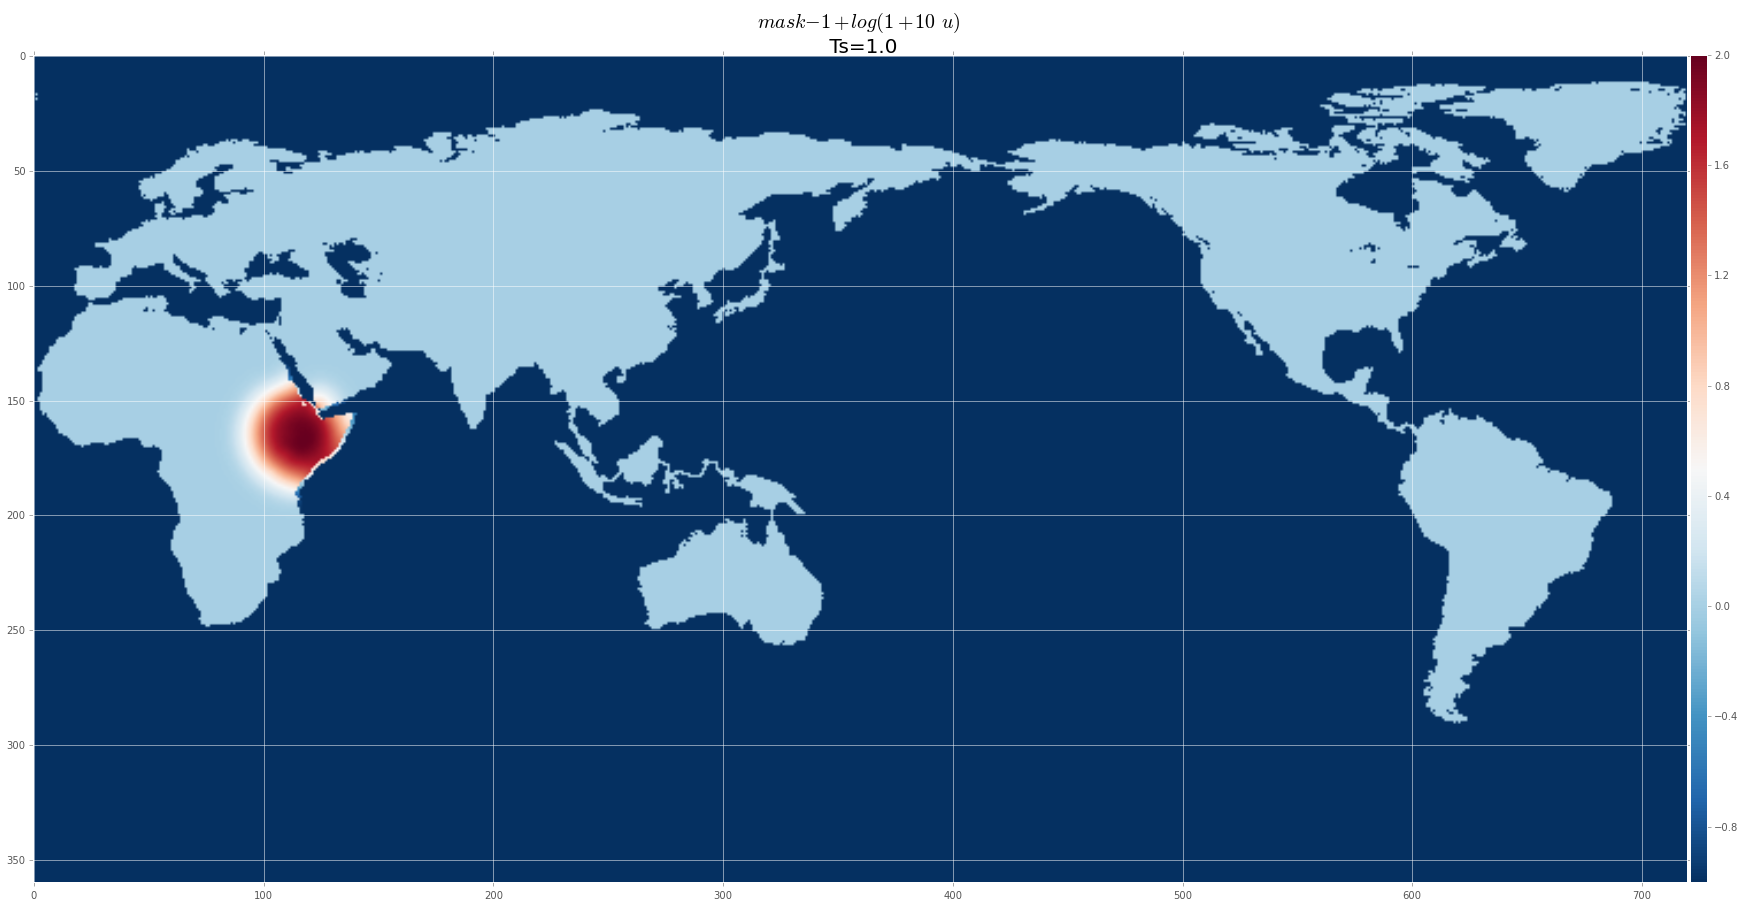

In [29]:
from matplotlib.pyplot import savefig
sim.plot()
#savefig('thesis/gfx/neumann2D_3rd.pdf')

#Dirichlet BC

=====Plotting Results=====


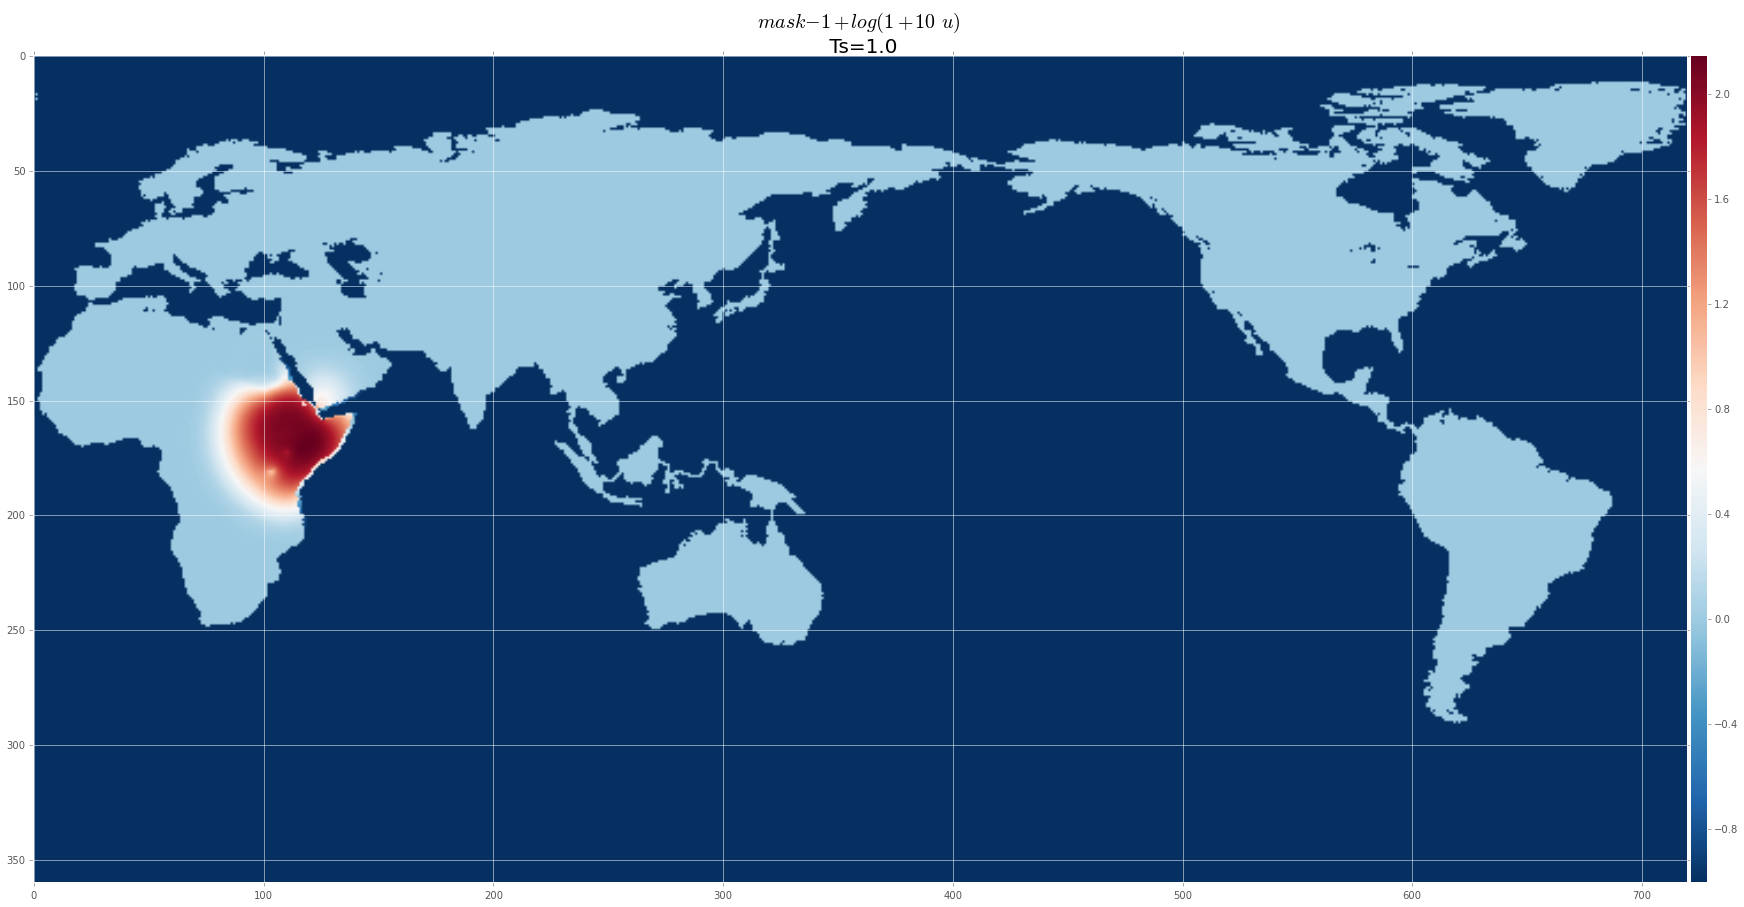

In [14]:
from matplotlib.pyplot import savefig
sim.plot() #Time: 211.22339577996172
#savefig('thesis/gfx/dirichlet2D.pdf')

In [7]:
print(sim.data.u.min())

nan


In [11]:
nInSeg

10

In [27]:
from matplotlib.pyplot import subplot
fig = pyplot.figure(figsize=(30,20))
subplot(211)
plot(1-u0[0:nInSeg+2]/kap0[0:nInSeg+2])
subplot(212)
plot(1-u0[0:nInSeg+2]/kaph[0:nInSeg+2])

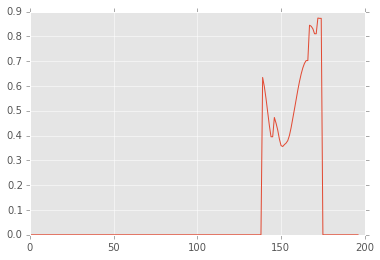

In [28]:
plot(u0[0:nInSeg+2])

In [34]:
import CmodulesNeumann1

In [1]:
import importlib
PymodulesNeumann=importlib.reload(PymodulesNeumann)

NameError: name 'PymodulesNeumann' is not defined

In [37]:
modules.godunovstep2(h,kcfl,u1[0:nInSeg+2],kap0[0:nInSeg+2],kaph[0:nInSeg+2])

array([ 0.1146703 ,  0.1146703 ,  0.09677253,  0.07508383,  0.06386956,
        0.07347091,  0.08855796,  0.09820115,  0.10370891,  0.10522554,
        0.1048124 ,  0.10342259,  0.10103033,  0.10251187,  0.11955233,
        0.15195687,  0.16905616,  0.19667687,  0.28468682,  0.37571368,
        0.43254491,  0.47524577,  0.50882869,  0.53582017,  0.55783757,
        0.57599921,  0.5911017 ,  0.60372452,  0.61429743,  0.62313733,
        0.63047184,  0.63644635,  0.64113716,  0.64457151,  0.64673718,
        0.6475916 ,  0.64707177,  0.64510171,  0.64160065,  0.6365039 ,
        0.62975552,  0.6213192 ,  0.61119805,  0.59947643,  0.58655929,
        0.57319346,  0.56040918,  0.55040571,  0.54358157,  0.53904664,
        0.53644775,  0.53593782,  0.53692712,  0.53867037,  0.54107216,
        0.54434672,  0.54880891,  0.55465756,  0.56183365,  0.56998153,
        0.57851528,  0.58682224,  0.59445951,  0.60120032,  0.6069627 ,
        0.61174665,  0.61559704,  0.61857992,  0.62077207,  0.62

In [40]:
PymodulesNeumann1.godunovstep2(h,kcfl,u1[0:nInSeg+2],kap0[0:nInSeg+2],kaph[0:nInSeg+2])

array([ 0.1146703 ,  0.1146703 ,  0.09677253,  0.07508383,  0.06386956,
        0.07347091,  0.08855796,  0.09820115,  0.10370891,  0.10522554,
        0.1048124 ,  0.10342259,  0.10103033,  0.10251187,  0.11955233,
        0.15195687,  0.16905616,  0.19667687,  0.28468682,  0.37571368,
        0.43254491,  0.47524577,  0.50882869,  0.53582017,  0.55783757,
        0.57599921,  0.5911017 ,  0.60372452,  0.61429743,  0.62313733,
        0.63047184,  0.63644635,  0.64113716,  0.64457151,  0.64673718,
        0.6475916 ,  0.64707177,  0.64510171,  0.64160065,  0.6365039 ,
        0.62975552,  0.6213192 ,  0.61119805,  0.59947643,  0.58655929,
        0.57319346,  0.56040918,  0.55040571,  0.54358157,  0.53904664,
        0.53644775,  0.53593782,  0.53692712,  0.53867037,  0.54107216,
        0.54434672,  0.54880891,  0.55465756,  0.56183365,  0.56998153,
        0.57851528,  0.58682224,  0.59445951,  0.60120032,  0.6069627 ,
        0.61174665,  0.61559704,  0.61857992,  0.62077207,  0.62

In [ ]:
%debug

In [51]:
sim.data.u.shape

(360, 720)

In [67]:
deltaLat = 180./sim.data.u.shape[0]
deltaLon = 360./sim.data.u.shape[0]
lats = np.linspace(-90,90,(180)/deltaLat)
lons = np.linspace(0,360, (360)/deltaLon)

In [69]:
lons.shape

(360,)

In [112]:
lat = lats_sites[2]
lon = lons_sites[2]
pixLat = int(-(lat-90)*sim.data.u.shape[0]/180)
pixLon= int((lon+18)*sim.data.u.shape[1]/360)

In [114]:
from  matplotlib import pyplot
import matplotlib.cm as cm
fig = pyplot.figure(figsize=(30,20))
pyplot.title('Title')
im = pyplot.imshow(sim.data.w_map[pixLat-100:pixLat+100, pixLon-100:pixLon+100], cmap = cm.RdBu_r)

In [12]:
from  matplotlib import pyplot
import matplotlib.cm as cm
fig = pyplot.figure(figsize=(30,20))
pyplot.subplot(311)
pyplot.title('Title')
colp = 3
colS = 120
colE = 146
rowS = 145
rowE = 145
im = pyplot.imshow(u[rowS-10:rowE+10,colS-10:colE+10], cmap = cm.RdBu_r)
#pyplot.clim(-1,1)
cb = pyplot.colorbar()
pyplot.subplot(312)
pyplot.title('w_L')
im = pyplot.imshow(w_L[rowS-10:rowE+10,colS-10:colE+10], cmap = cm.RdBu_r)
#im = pyplot.imshow(w_L*(1-wt0)+w_L*wt0, cmap = cm.RdBu_r)
#pyplot.clim(-1,1)
cb = pyplot.colorbar()
pyplot.subplot(313)
pyplot.title('w_H')
im = pyplot.imshow(w_H[rowS-10:rowE+10,colS-10:colE+10], cmap = cm.RdBu_r)
#im = pyplot.imshow(w_L*(1-wth)+w_H*wth, cmap = cm.RdBu_r)
#pyplot.clim(-1,1)
cb = pyplot.colorbar()

In [41]:
from matplotlib.pyplot import subplot
fig = pyplot.figure(figsize=(30,20))
subplot(311)
plot(m_LH[rowStart:rowEnd+1,col])
subplot(312)
plot(w_L[rowStart:rowEnd+1,col])
subplot(313)
plot(w_H[rowStart:rowEnd+1,col])
print(m_LH[rowStart:rowEnd+1,col])
print(w_L[rowStart:rowEnd+1,col])
print(w_H[rowStart:rowEnd+1,col])

[1 1 1 1 1 1 1 1 1 1]
[ 0.49691717  0.51426955  0.53179741  0.55227463  0.57428895  0.59528144
  0.61579882  0.6329069   0.64690272  0.66019712]
[  3.23729773e-02   5.35018427e-02   7.32533072e-02   7.20473583e-02
   6.42278012e-02   2.54940434e-02   1.38866739e-02   5.44186527e-03
   8.61405000e-05   8.61405000e-05]


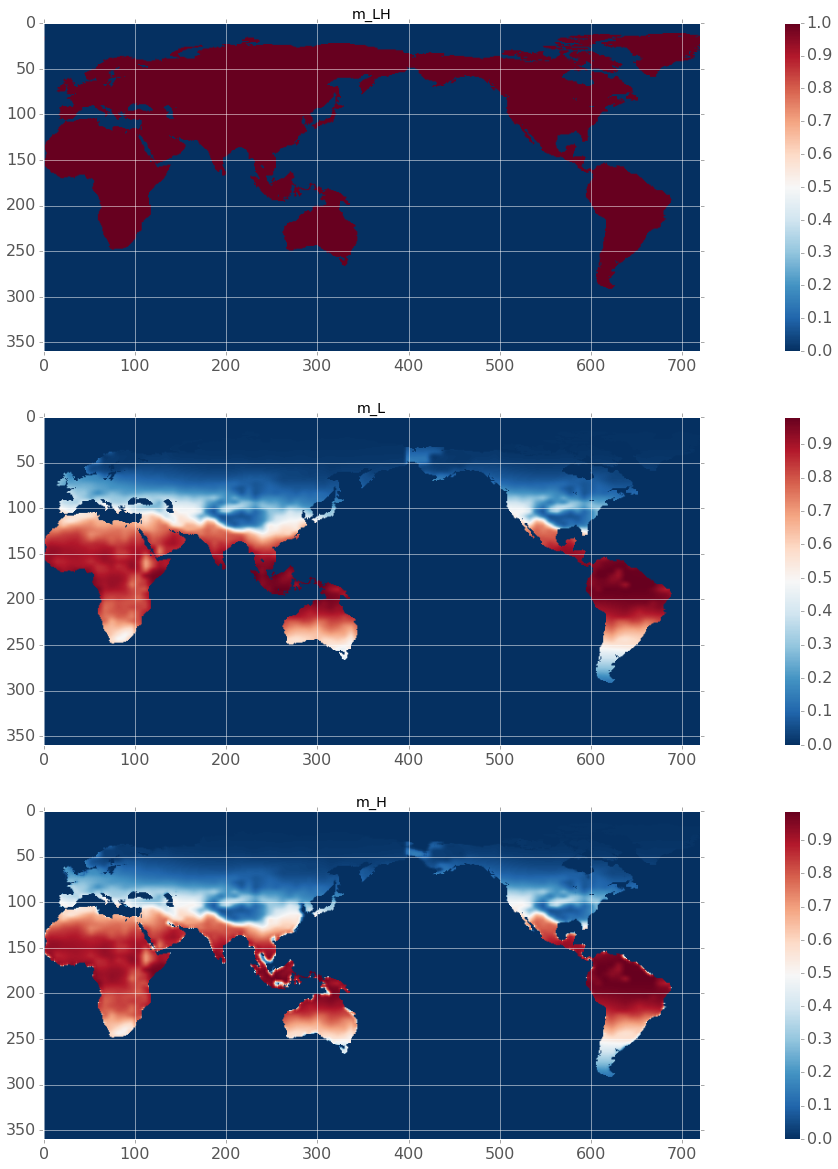

In [28]:
from  matplotlib import pyplot
import matplotlib.cm as cm
fig = pyplot.figure(figsize=(30,20))
pyplot.subplot(311)
pyplot.title('m_LH')
im = pyplot.imshow(m_LH, cmap = cm.RdBu_r)
#pyplot.clim(-1,1)
cb = pyplot.colorbar()
pyplot.subplot(312)
pyplot.title('m_L')
im = pyplot.imshow(w_L, cmap = cm.RdBu_r)
#pyplot.clim(-1,1)
cb = pyplot.colorbar()
pyplot.subplot(313)
pyplot.title('m_H')
im = pyplot.imshow(w_H, cmap = cm.RdBu_r)
#pyplot.clim(-1,1)
cb = pyplot.colorbar()

In [3]:
#plot(nxsegs)
#plot(xstart_seg)
#plot(xend_seg)

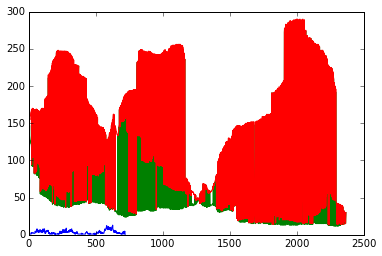

In [4]:
#plot(nysegs)
#plot(ystart_seg)
#plot(yend_seg)

In [10]:
locX = 0
#half-step1 in X
for row in xrange(0,sim.data.NY):
    nSegs = nxsegs[row] #Number of segments 
    for k in xrange(0,nSegs):
        colStart=xstart_seg[locX+k] #From: segment starts
        colEnd=xend_seg[locX+k] #To:segmend ends
        nInSeg=colEnd-colStart+1 #Number of inner segments
        u1[0] = 0 
        u1[nInSeg+1] = 0
        #print 'u',u.shape
        #print 'i',i
        #print 'jstart',jstart
        #print'jend',jend
        u1[1:nInSeg+1] = u[row,colStart:colEnd+1]
        #ut = godunovstep1(ninseg+2,h,kcfl,u1,sc1,sc2)
        #Booster Subroutine
        ut = modules.godunovstep1(h,kcfl,u1[0:nInSeg+2])
        if (ut<0).any():
            print '1st Half-Step1 X'
            print 'ut:',ut
            #break
        else:
            u[row,colStart:colEnd+1] = ut[1:nInSeg+1]

    locX = locX + nSegs #Number of scanned segments

In [13]:
col=110
nSegs = nysegs[col] #Number of segments 
locY =381
k = 4

In [14]:
rowStart=ystart_seg[locY+k]
rowEnd=yend_seg[locY+k]
nInSeg=rowEnd-rowStart+1
#print j #69 ??????
#print k #0
#print istart #617
#print iend #618
#print ninseg #2
u0[0] = 0 
u0[nInSeg+1] = 0
#print 'it:', it #it 17, 67, 0
#print 'col:', col
#print 'rowStart:',rowStart #:678???
#print 'rowEnd:',rowEnd #679??
#print 'u0:', u0[1:nInSeg+1].shape # (2,), (26,), (2,)
#print 'u:',u[rowStart:rowEnd+1,col].shape # (0,), (0,), (0,)
u0[1:nInSeg+1] = u[rowStart:rowEnd+1,col]
kap0[0] = 1 
kap0[nInSeg+1] = 1
#print 'kaph', kaph[1:ninseg+1].shape
#print 'w_L', w_L[j,istart:iend+1].shape
#print 'w_H', w_H[j,istart:iend+1].shape
kap0[1:nInSeg+1] = w_L[rowStart:rowEnd+1,col]*(1-wt0) + w_H[rowStart:rowEnd+1,col]*wt0
#if kap0[1:nInSeg+1]==0
kaph[0] = 1 
kaph[nInSeg+1] = 1
kaph[1:nInSeg+1] = w_L[rowStart:rowEnd+1,col]*(1-wth) + w_H[rowStart:rowEnd+1,col]*wth
#ut = godunovstep2(ninseg+2,h,kcfl,u0,sc1,sc2,kap0,kaph)
#Booster Subroutine
#if kap0[0:nInSeg+2].any()==0:
#    print 'it:', it
#    print 'kap0:',kap0
#if kaph[0:nInSeg+2].any() ==0:
#    print 'it:', it
#    print 'kaph:',kaph
ut = modules.godunovstep2(h,kcfl,u0[0:nInSeg+2],kap0[0:nInSeg+2],kaph[0:nInSeg+2])

In [3]:
sim = SmallSimulation()

=====Initializing small simulation=====
 INPUT Parameter summary: 
   Number of time steps: NT=2001 
   Plotting interval: NPLT=40 
   Diffusion coeff: Kyb = 2.080000e+02 (in km^2/yr)
   Growth rate: Ryb = 1.670000e-03 (in yr^{-1})
 MAP SIZE: NX=Grid_size_x=100, NY=Grid_size_y=50 
   CELL size: dx=dy = 404.8 (km)=   0.8 (eq. (3) units)
   BOX: X x Y = [-40.1,  40.1] x [-20.1,  20.1]
   eq. (3) step size h=4.089455e-02, and CFL number=3.108425e-02 



In [4]:
sim.run()

=====Small Simulation Starting=====
   Start time Ts= 50.0 (kya), NPP frame kstart=25

   End time   Te=  1.0 (kya), NPP frame kend=60

   50.0
   49.0
   48.0
   47.0
   46.1
   45.1
   44.1
   43.1
   42.1
   41.2
   40.2
   39.2
   38.2
   37.2
   36.3
   35.3
   34.3
   33.3
   32.3
   31.4
   30.4
   29.4
   28.4
   27.4
   26.5
   25.5
   24.5
   23.5
   22.5
   21.6
   20.6
   19.6
   18.6
   17.7
   16.7
   15.7
   14.7
   13.7
   12.8
   11.8
   10.8
   9.82
   8.84
   7.86
   6.88
   5.90
   4.92
   3.94
   2.96
   1.98
   1.00
=====Small simulation completed=====
   Main Loop Time: 33.7230439186


In [5]:
sim.plot()

=====Plotting Resutls=====


In [10]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

In [11]:
labels = ['7','8','9','6','5','4','3','2','1']
names = ['Tagua Tagua', 'Monte Verde', 'Fell\'s Cave', 'Pedra Furada', 'Pikimachay', 'Pachamachay', 'El Inga', 'Taima-Taima','Meadowcroft']
lats_sites = np.array([-34.43944, -41.504711, -52.03333, -8.83333, -13.040833, -10.295278, -0.3, 11.49918, 40.287995])
lons_sites = 360+ np.array([-71.07611, -73.20444, -70.05, -42.55333, -74.224167, -76.425000, -78.3333, -69.522203, -80.489063])
arrival = np.array([11500, 33000, 11000, 35000, 15000, 10500, 9000, 13000, 19000])

In [20]:
colors=plt.cm.get_cmap('RdBu_r')

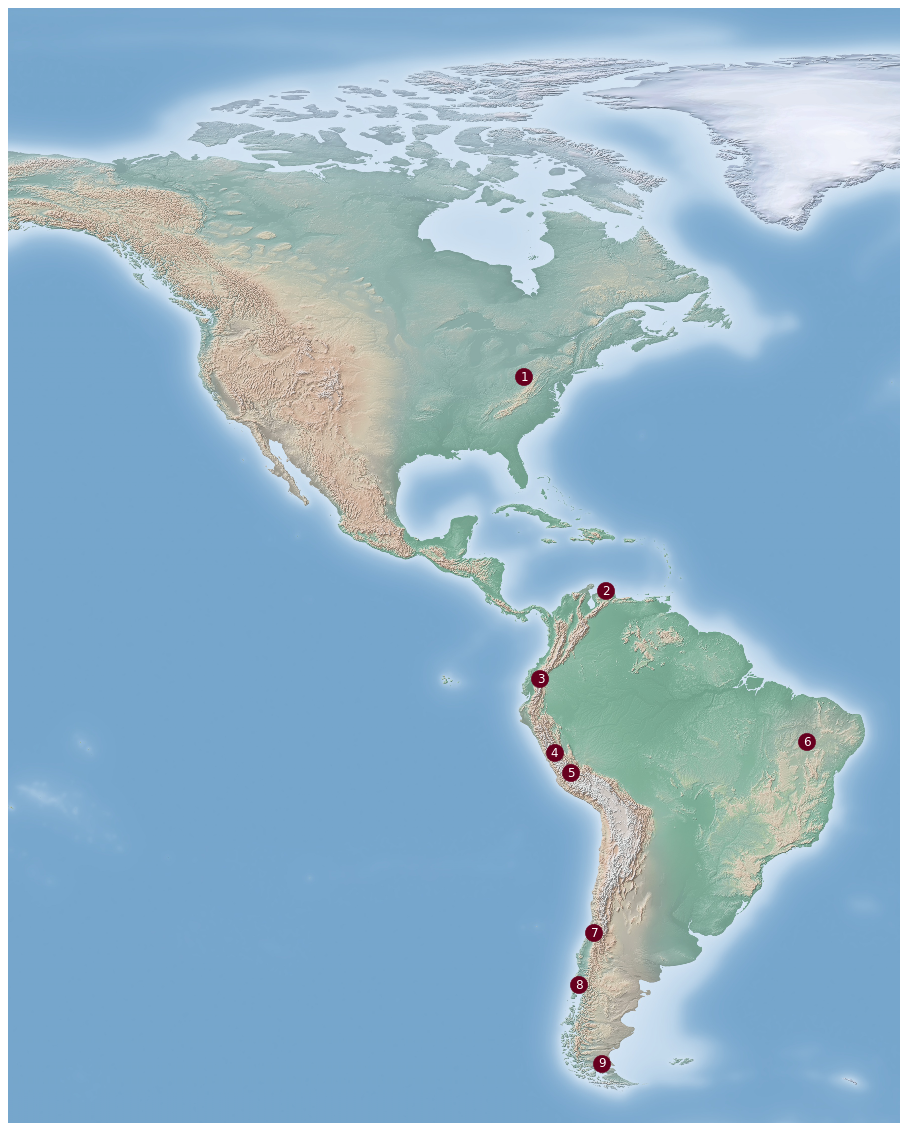

In [38]:
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
fig=plt.figure(figsize=(30,20))
#m = Basemap(projection='ortho',lat_0=25,lon_0=50,resolution='l')
#m = Basemap(projection='cyl',lat_0=25,lon_0=160,resolution='l')
m = Basemap(projection='cyl',llcrnrlon=210,llcrnrlat=-60,urcrnrlon=360-30,urcrnrlat=90,lat_0=60,lon_0=180,resolution='l')
#map = Basemap(projection='cyl',lat_0=45,lon_0=-100,resolution='l')
# draw coastlines, country boundaries, fill continents.
#m.drawcoastlines(linewidth=0.25)
#m.bluemarble()
m.shadedrelief()
#m.drawlsmask(ocean_color='aqua',lakes=True)

#map.drawcountries(linewidth=0.25)
#m.fillcontinents(color=colors(0.5),lake_color=colors(-1))
# draw the edge of the map projection region (the projection limb)
#m.drawmapboundary(fill_color='white')
# draw lat/lon grid lines every 30 degrees.
#map.drawmeridians(np.arange(0,360,30))
#map.drawparallels(np.arange(-90,90,30))
# make up some data on a regular lat/lon grid.
#nlats = 73; nlons = 145; delta = 2.*np.pi/(nlons-1)
nlats = sim.data.u.shape[0]; 
nlons=sim.data.u.shape[1]; 
delta = 2.*np.pi/(nlons-1);
lats = (0.5*np.pi-delta*np.indices((nlats,nlons))[0,:,:])
lons = (delta*np.indices((nlats,nlons))[1,:,:])
#wave = 0.75*(np.sin(2.*lats)**8*np.cos(4.*lons))
#mean = 0.5*np.cos(2.*lats)*((np.sin(2.*lats))**2 + 2.)
# compute native map projection coordinates of lat/lon grid.
x, y = m(lons*180./np.pi-18, lats*180./np.pi)

x_site, y_site = m(lons_sites, lats_sites)

# contour data over the map.
m.scatter(x_site,y_site,300,marker='o',color=colors(1.0))

for i, label in enumerate(labels):
    plt.text(x_site[i],y_site[i],label,fontsize=12, ha='center',va='center',color='w')

#cs = m.contourf(x,y,sim.data.w_map-1+log(1+10*sim.data.u),cmap=cm.RdBu_r,extend='both',alpha=1.0,origin='lower',rasterized=True)
#cs = m.contourf(x,y,sim.data.u,cmap=cm.RdBu_r,extend='both',alpha=0.4,origin='lower',rasterized=True)
#m.pcolormesh(lons, lats, sim.data.u, shading='flat',cmap=plt.cm.RdBu_r)
#map.bluemarble()
#m.colorbar()

#plt.title('contour lines over filled continent background')
#plt.show()
#plt.savefig('thesis/gfx/front.pdf')
#plt.savefig('thesis/gfx/front.png')
#plt.savefig('thesis/gfx/dirichlet2DMap.png')
#plt.savefig('thesis/gfx/neumann2DMap.png')
plt.savefig('thesis/gfx/archSites.png')

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
fig=plt.figure(figsize=(40,30))
#m = Basemap(projection='ortho',lat_0=25,lon_0=50,resolution='l')
m = Basemap(projection='cyl',lat_0=25,lon_0=160,resolution='l')
#map = Basemap(projection='cyl',lat_0=45,lon_0=-100,resolution='l')
# draw coastlines, country boundaries, fill continents.
#m.drawcoastlines(linewidth=0.25)
m.bluemarble()
#map.drawcountries(linewidth=0.25)
#map.fillcontinents(color='coral',lake_color='aqua')
# draw the edge of the map projection region (the projection limb)
#map.drawmapboundary(fill_color='aqua')
# draw lat/lon grid lines every 30 degrees.
#map.drawmeridians(np.arange(0,360,30))
#map.drawparallels(np.arange(-90,90,30))
# make up some data on a regular lat/lon grid.
#nlats = 73; nlons = 145; delta = 2.*np.pi/(nlons-1)
nlats = sim.data.u.shape[0]; 
nlons=sim.data.u.shape[1]; 
delta = 2.*np.pi/(nlons-1);
lats = (0.5*np.pi-delta*np.indices((nlats,nlons))[0,:,:])
lons = (delta*np.indices((nlats,nlons))[1,:,:])
#wave = 0.75*(np.sin(2.*lats)**8*np.cos(4.*lons))
#mean = 0.5*np.cos(2.*lats)*((np.sin(2.*lats))**2 + 2.)
# compute native map projection coordinates of lat/lon grid.
x, y = m(lons*180./np.pi-18, lats*180./np.pi)

# contour data over the map.
#cs = m.contourf(x,y,sim.data.w_map-1+log(1+10*sim.data.u),cmap=cm.RdBu_r,extend='both',alpha=1.0,origin='lower',rasterized=True)
cs = m.contourf(x,y,sim.data.u,cmap=cm.RdBu_r,extend='both',alpha=0.4,origin='lower',rasterized=True)
m.pcolormesh(lons, lats, sim.data.u, shading='flat',cmap=plt.cm.RdBu_r)
#map.bluemarble()
#m.colorbar()

#plt.title('contour lines over filled continent background')
#plt.show()
#plt.savefig('thesis/gfx/front.pdf')
#plt.savefig('thesis/gfx/front.png')
#plt.savefig('thesis/gfx/dirichlet2DMap.png')
#plt.savefig('thesis/gfx/neumann2DMap.png')

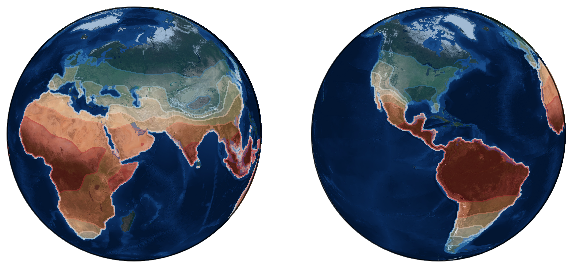

In [8]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
fig=plt.figure(figsize=(10,20))
plt.subplot(121)
m = Basemap(projection='ortho',lat_0=25,lon_0=50,resolution='l')
m.bluemarble()
nlats = sim.data.u.shape[0]; 
nlons=sim.data.u.shape[1]; 
delta = 2.*np.pi/(nlons-1);
lats = (0.5*np.pi-delta*np.indices((nlats,nlons))[0,:,:])
lons = (delta*np.indices((nlats,nlons))[1,:,:])
# compute native map projection coordinates of lat/lon grid.
x, y = m(lons*180./np.pi-18, lats*180./np.pi)

# contour data over the map.
cs = m.contourf(x,y,sim.data.u,cmap=cm.RdBu_r,extend='both',alpha=0.4,origin='lower',rasterized=True)
m.pcolormesh(lons, lats, sim.data.u, shading='flat',cmap=plt.cm.RdBu_r)


plt.subplot(122)
m = Basemap(projection='ortho',lat_0=15,lon_0=-80,resolution='l')
m.bluemarble()
nlats = sim.data.u.shape[0]; 
nlons=sim.data.u.shape[1]; 
delta = 2.*np.pi/(nlons-1);
lats = (0.5*np.pi-delta*np.indices((nlats,nlons))[0,:,:])
lons = (delta*np.indices((nlats,nlons))[1,:,:])
# compute native map projection coordinates of lat/lon grid.
x, y = m(lons*180./np.pi-18, lats*180./np.pi)

# contour data over the map.
cs = m.contourf(x,y,sim.data.u,cmap=cm.RdBu_r,extend='both',alpha=0.4,origin='lower',rasterized=True)
m.pcolormesh(lons, lats, sim.data.u, shading='flat',cmap=plt.cm.RdBu_r)

#plt.title('contour lines over filled continent background')
#plt.show()
#plt.savefig('thesis/gfx/front.pdf')
#plt.savefig('thesis/gfx/front.png')
#plt.savefig('thesis/gfx/dirichlet3D.png')
plt.savefig('thesis/gfx/neumann3D.png')

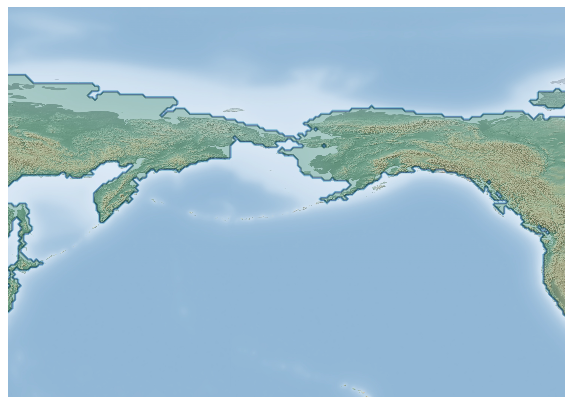

In [19]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
fig4=plt.figure(figsize=(10,10))
m = Basemap(projection='cyl',llcrnrlon=180-40,llcrnrlat=60-40,urcrnrlon=180+60,urcrnrlat=90,lat_0=60,lon_0=180,resolution='l')

#map = Basemap(projection='cyl',lat_0=45,lon_0=-100,resolution='l')
# draw coastlines, country boundaries, fill continents.
#m.drawcoastlines(linewidth=0.25)
m.shadedrelief()
#m.bluemarble()
#map.drawcountries(linewidth=0.25)
#map.fillcontinents(color='coral',lake_color='aqua')
# draw the edge of the map projection region (the projection limb)
#map.drawmapboundary(fill_color='aqua')
# draw lat/lon grid lines every 30 degrees.
#map.drawmeridians(np.arange(0,360,30))
#map.drawparallels(np.arange(-90,90,30))
# make up some data on a regular lat/lon grid.
#nlats = 73; nlons = 145; delta = 2.*np.pi/(nlons-1)
nlats = sim.data.u.shape[0]; 
nlons=sim.data.u.shape[1]; 
delta = 2.*np.pi/(nlons-1);
lats = (0.5*np.pi-delta*np.indices((nlats,nlons))[0,:,:])
lons = (delta*np.indices((nlats,nlons))[1,:,:])
#wave = 0.75*(np.sin(2.*lats)**8*np.cos(4.*lons))
#mean = 0.5*np.cos(2.*lats)*((np.sin(2.*lats))**2 + 2.)
# compute native map projection coordinates of lat/lon grid.
x, y = m(lons*180./np.pi-18, lats*180./np.pi)

# contour data over the map.
#cs = m.contourf(x,y,sim.data.w_map-1+log(1+10*sim.data.u),cmap=cm.RdBu_r,extend='both',alpha=1.0,origin='lower',rasterized=True)
cs = m.contourf(x,y,sim.data.w_map,cmap=cm.ocean_r,extend='both',alpha=0.2,origin='lower',rasterized=True)
#m.pcolormesh(lons, lats, sim.data.w_map, shading='flat',cmap=plt.cm.ocean_r)
#map.bluemarble()
#m.colorbar()

#plt.title('contour lines over filled continent background')
#plt.show()
#plt.savefig('thesis/gfx/front.pdf')
plt.savefig('thesis/gfx/bering10.png')